The goal of this project is to use supervised machine learning techniques to forecast the weekly sales of Walmart stores. The data source is a Kaggle dataset that contains historical sales data. Each store contains a number of departments, and the dataset also includes information about the store size, the type of store, the regional unemployment rate, the consumer price index, the fuel price, the temperature, the holiday weeks, and the markdowns. The dataset covers the period from February 2010 to October 2012.


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import ttest_ind
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import warnings
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import missingno as no
import datetime
import numpy as np
import plotly.graph_objects as go
import scipy.stats as stats
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('Walmart Sales.csv')

In [3]:
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [4]:
df.tail()

,Store,Dept,Date,Weekly_Sales,IsHoliday
421565,45,98,2012-09-28,508.37,False
421566,45,98,2012-10-05,628.10,False
421567,45,98,2012-10-12,1061.02,False
421568,45,98,2012-10-19,760.01,False
421569,45,98,2012-10-26,1076.80,False


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 13.3+ MB


<AxesSubplot:>

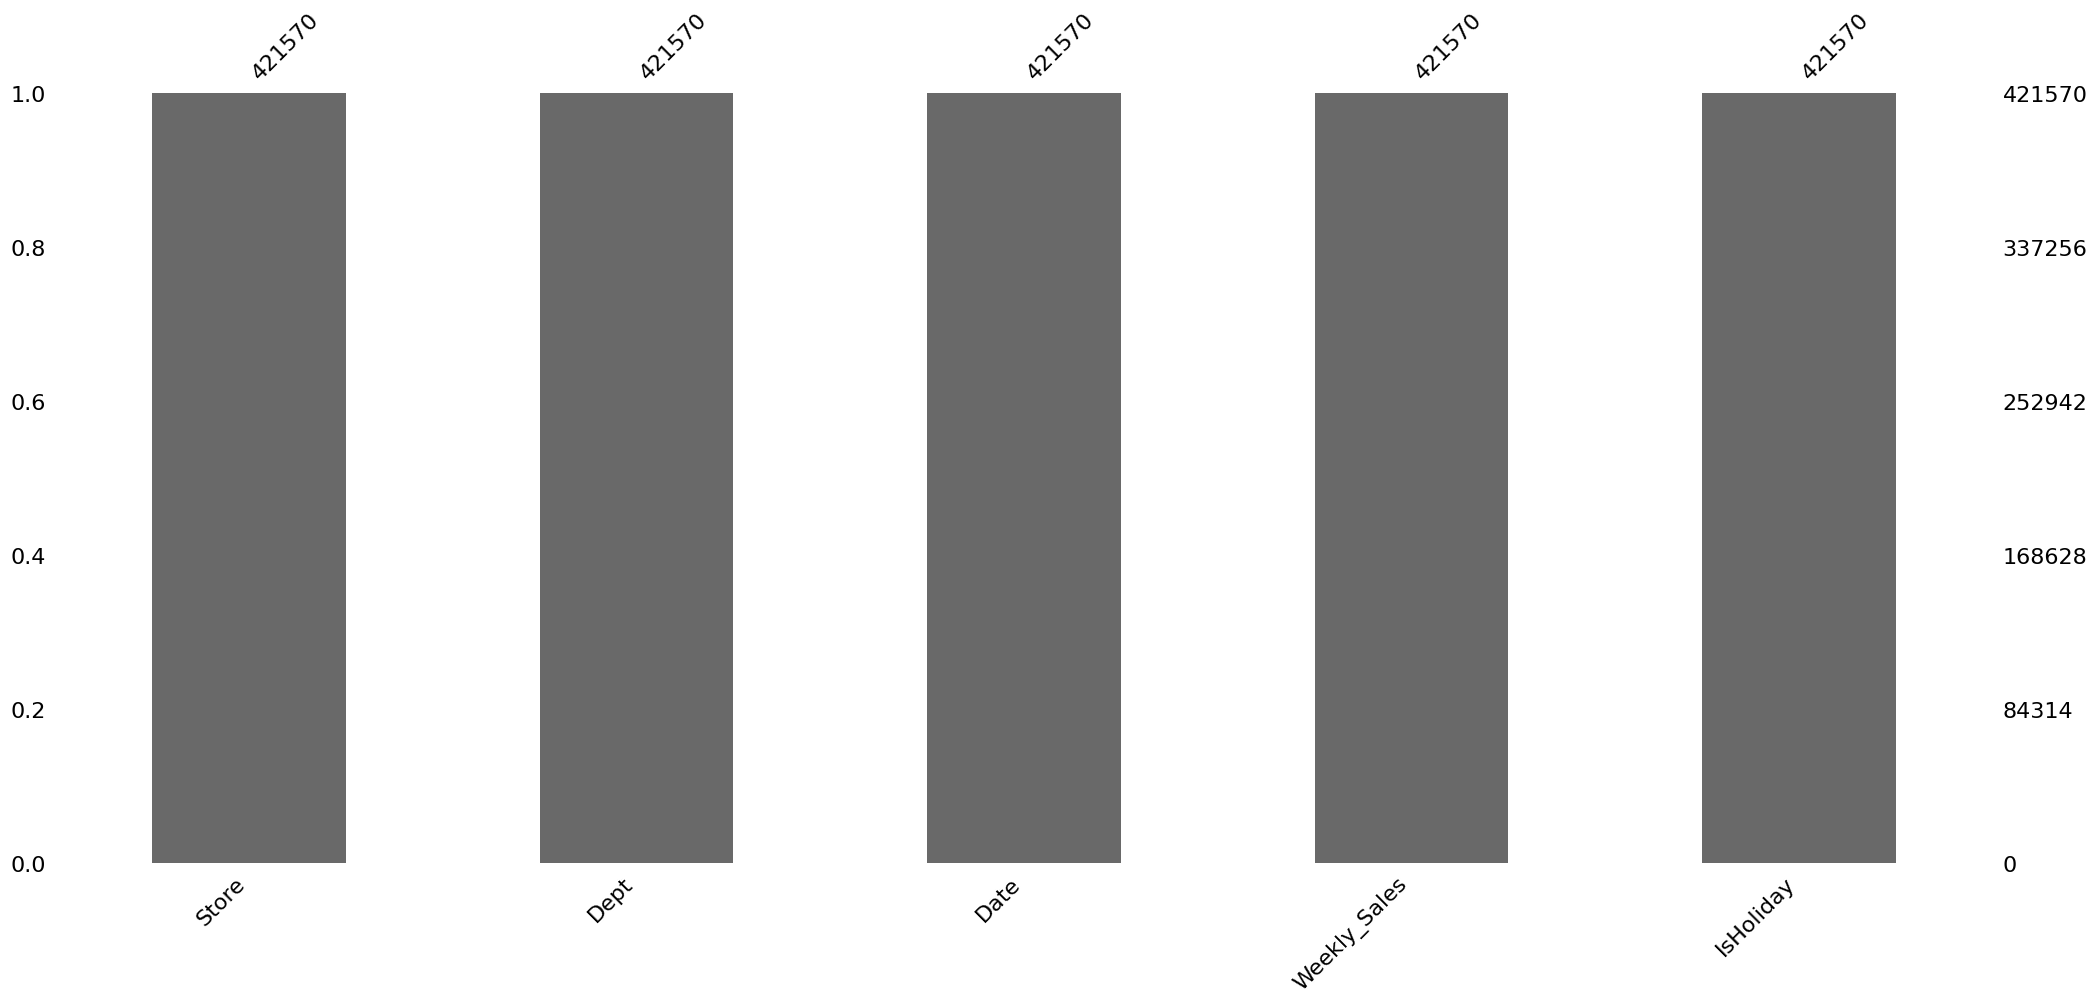

In [6]:
no.bar(df)

In [7]:
df['Date'] = pd.to_datetime(df['Date'])

In [8]:
df.describe()


,Store,Dept,Weekly_Sales
count,421570.000000,421570.000000,421570.000000
mean,22.200546,44.260317,15981.258123
std,12.785297,30.492054,22711.183519
min,1.000000,1.000000,-4988.940000
25%,11.000000,18.000000,2079.650000
50%,22.000000,37.000000,7612.030000
75%,33.000000,74.000000,20205.852500
max,45.000000,99.000000,693099.360000


In [9]:
df.isnull().sum()


Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
dtype: int64

In [10]:
#What is the total weekly sales for all stores?
total_weekly_sales = df['Weekly_Sales'].sum()
print("Total weekly sales for all stores:", total_weekly_sales)

Total weekly sales for all stores: 6737218987.11


In [11]:
#What is the total number of stores?
stores_cnt = df[['Store']].nunique(axis=0).values[0]
print(" total number of stores:", stores_cnt)

 total number of stores: 45


In [12]:
#What is the total number of departmants?
stores_cnt = df[['Dept']].nunique(axis=0).values[0]
print(" total number of departmants:", stores_cnt)

 total number of departmants: 81


In [25]:
#Which store has the highest weekly sales?
max_weekly_sales = df.groupby('Store')['Weekly_Sales'].sum().idxmax()
print("Store with the highest weekly sales:", max_weekly_sales)

Store with the highest weekly sales: 20


In [26]:
#Which store has the lowest weekly sales?
min_weekly_sales = df.groupby('Store')['Weekly_Sales'].sum().idxmin()
print("Store with the lowest weekly sales:", min_weekly_sales)

Store with the lowest weekly sales: 33


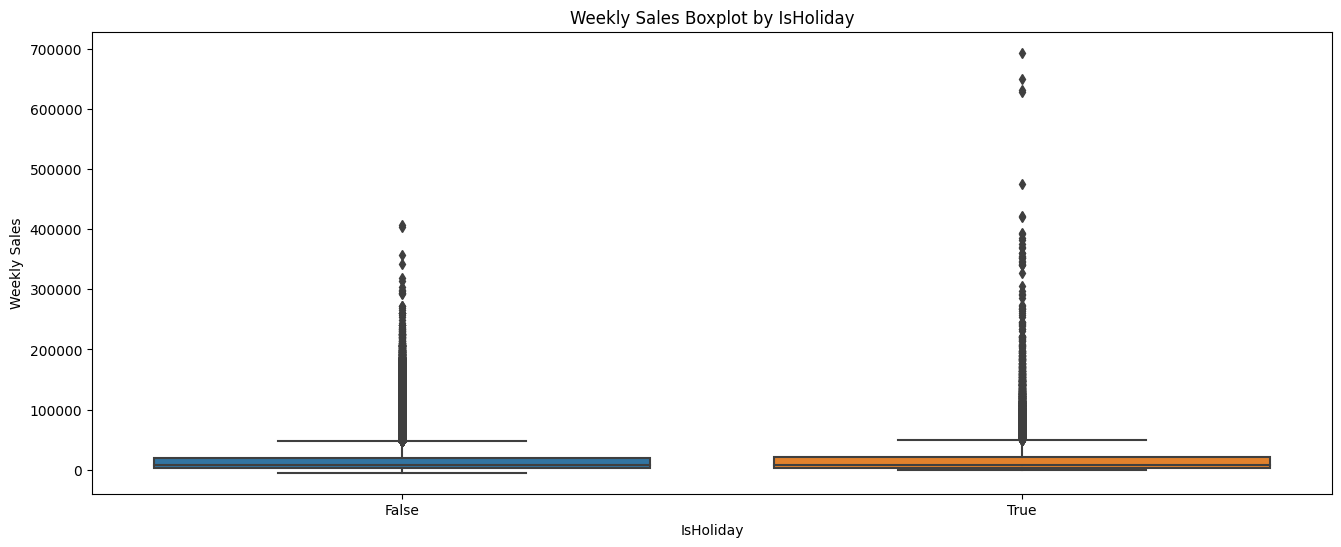

In [44]:
# Checking for outliers or unusual observations in the data and find difference between holidays and non holidays
plt.figure(figsize=(16, 6)) 
sns.boxplot(data=df, x='IsHoliday', y='Weekly_Sales')
plt.title('Weekly Sales Boxplot by IsHoliday')
plt.xlabel('IsHoliday')
plt.ylabel('Weekly Sales')

plt.show()

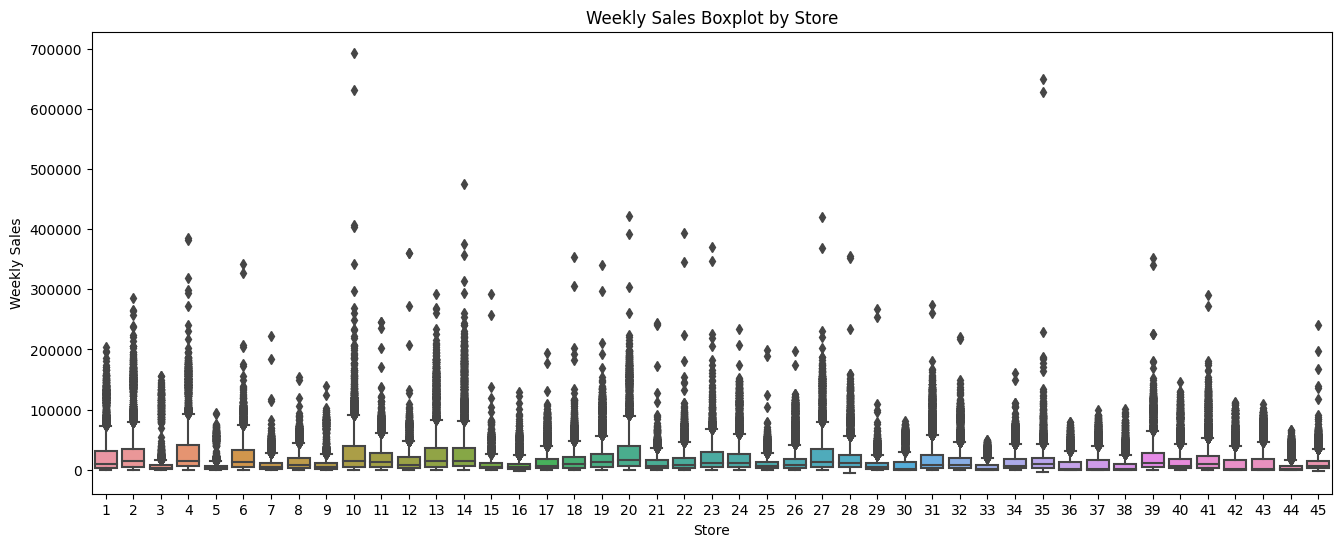

In [43]:
# Checking for outliers or unusual observations in the data and find difference between diffrent stores

plt.figure(figsize=(16, 6)) 
sns.boxplot(data=df, x='Store', y='Weekly_Sales')
plt.title('Weekly Sales Boxplot by Store')
plt.xlabel('Store')
plt.ylabel('Weekly Sales')

plt.show()

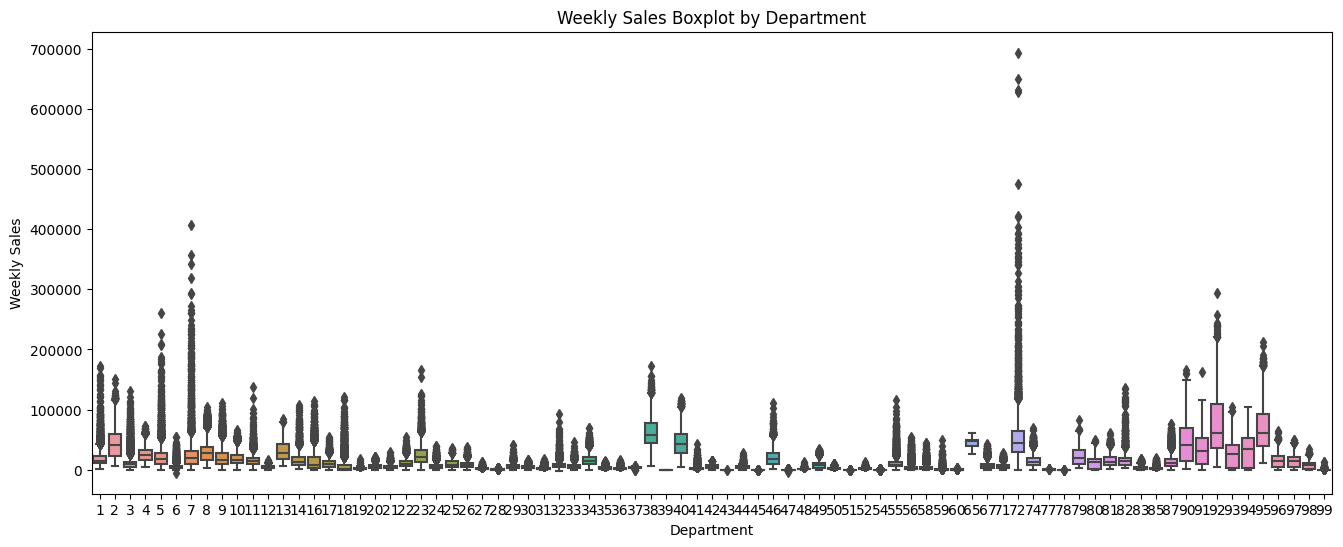

In [42]:
plt.figure(figsize=(16, 6)) 
sns.boxplot(data=df, x='Dept', y='Weekly_Sales')
plt.title('Weekly Sales Boxplot by Department')
plt.xlabel('Department')
plt.ylabel('Weekly Sales')

plt.show()

In [36]:
from statsmodels.formula.api import ols

# Assuming you have your data in a dataframe named 'df'

# Performing the ANOVA test
model = ols('Weekly_Sales ~ Store + Dept + IsHoliday', data=df).fit()
anova_table = sm.stats.anova_lm(model)

# Analyzing the ANOVA result
p_values = anova_table['PR(>F)']
alpha = 0.05  # Significance level

# Checking the significance of each variable
store_significant = p_values['Store'] < alpha
dept_significant = p_values['Dept'] < alpha
isholiday_significant = p_values['IsHoliday'] < alpha

# Printing the significance of each variable
print("Store is significant:", store_significant)
print("Dept is significant:", dept_significant)
print("IsHoliday is significant:", isholiday_significant)

Store is significant: True
Dept is significant: True
IsHoliday is significant: True


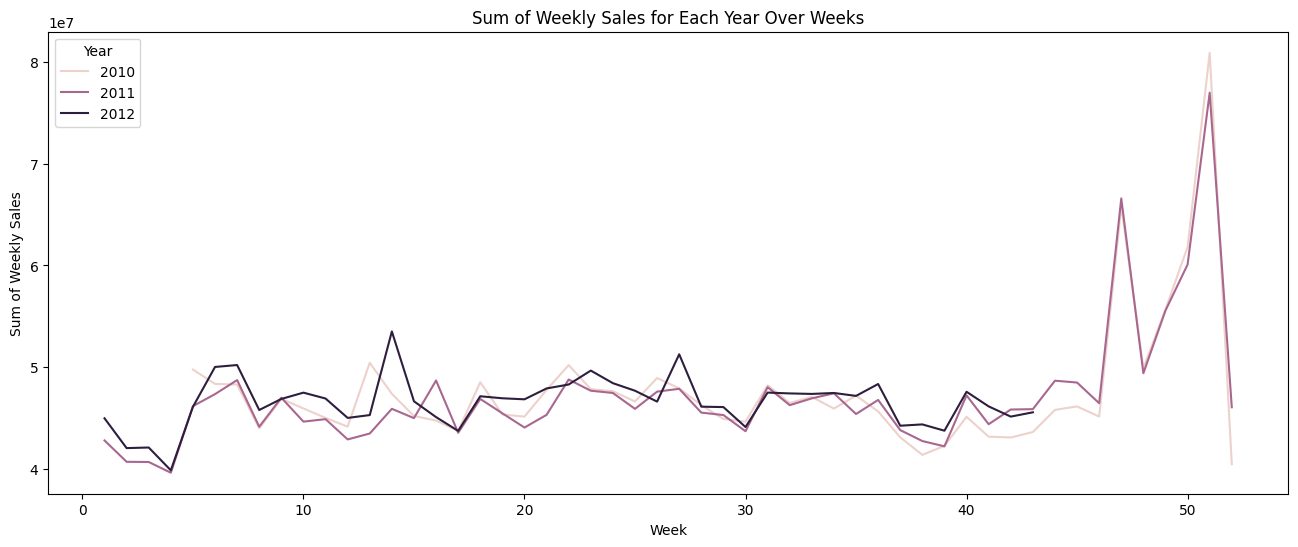

In [47]:
df['Year'] = df['Date'].dt.year

# Grouping by year and the week number, and summing the weekly sales
weekly_sales_yearly = df.groupby(['Year', df['Date'].dt.week])['Weekly_Sales'].sum().reset_index()
weekly_sales_yearly.rename(columns={'Date': 'Week'}, inplace=True)

plt.figure(figsize=(16, 6)) 
# Creating the line plot using Seaborn
sns.lineplot(data=weekly_sales_yearly, x='Week', y='Weekly_Sales', hue='Year')

plt.title('Sum of Weekly Sales for Each Year Over Weeks')
plt.xlabel('Week')
plt.ylabel('Sum of Weekly Sales')

plt.show()

In [48]:
df['IsHoliday'].replace({True: 1, False: 0}, inplace=True)

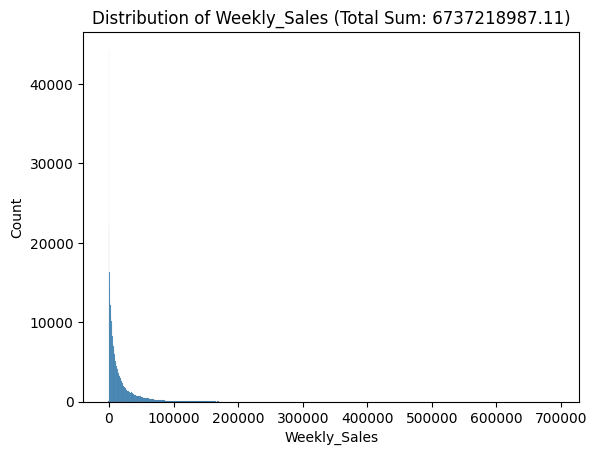

In [50]:
# Calculate the sum of Weekly_Sales
sum_weekly_sales = df['Weekly_Sales'].sum()

# Plot the distribution of the 'Weekly_Sales' column
sns.histplot(data=df, x='Weekly_Sales')

plt.title(f"Distribution of Weekly_Sales (Total Sum: {sum_weekly_sales})")
plt.xlabel("Weekly_Sales")
plt.ylabel("Count")

plt.show()

In [51]:
df = df[df.Weekly_Sales>0]

Estimated lambda value: 0.21377431116577392


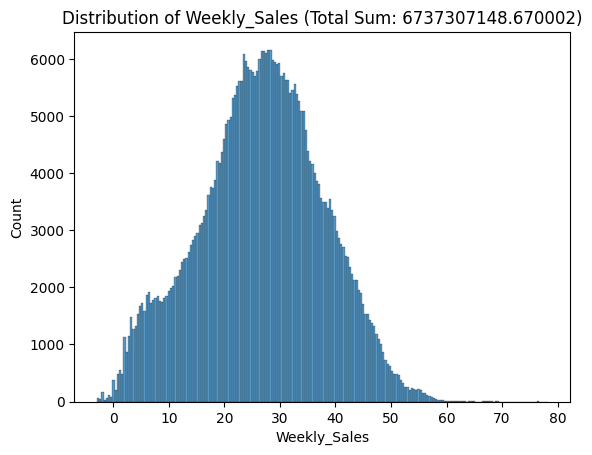

In [54]:
# Apply Box-Cox transformation to make the distribution more normally distributed
transformed_values, lambda_value = stats.boxcox(df['Weekly_Sales'])
df['transformed_values'] = transformed_values
# Print the estimated lambda value
print("Estimated lambda value:", lambda_value)

# Plot the distribution of the 'Weekly_Sales' column
sns.histplot(data=df, x='transformed_values')

plt.title(f"Distribution of Weekly_Sales (Total Sum: {sum_weekly_sales})")
plt.xlabel("Weekly_Sales")
plt.ylabel("Count")

plt.show()

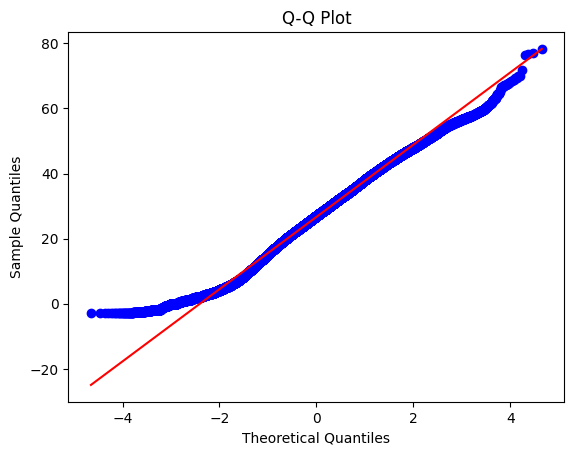

In [27]:
# Create the Q-Q plot
stats.probplot(df['transformed_values'], dist="norm", plot=plt)

# Customize the plot
plt.title("Q-Q Plot")
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Sample Quantiles")

# Display the plot
plt.show()


On a Q-Q plot left-skewed data appears as a concave curve (the opposite of right-skewed data)

In [29]:

# Calculate the skewness of the 'Values' column
skewness = df['transformed_values'].skew()
print("Skewness:", skewness)


Skewness: -0.0757289735253769


The skewness transformation is -0.0757, which is very close to zero. This indicates that  distribution is approximately symmetrical, and does not need any transformation to improve normality.

In [30]:


# Convert 'Date' to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Sort the DataFrame by 'Date', 'Store', and 'Dept' if it's not already sorted
df = df.sort_values(by=['Date', 'Store', 'Dept','IsHoliday'])

# Define the number of lags to create
num_lags = 5  # Example: Creating 2 lagged values

# Create lagged features based on 'Store' and 'Dept' for the 'Sales' variable
for lag in range(1, num_lags + 1):
    df[f'transformed_values_{lag}'] = df.groupby(['Store', 'Dept', 'IsHoliday'])['transformed_values'].shift(lag)

df = pd.DataFrame(df)

df.dropna(inplace=True)

In [36]:
import category_encoders as ce

# Create a target encoder object
encoder = ce.TargetEncoder(cols=['Store','Dept', 'IsHoliday'])

# Fit and transform the data
encoded_data = encoder.fit_transform(df[['Store','Dept', 'IsHoliday']], df['transformed_values'])

In [38]:
df[['Store_e','Dept_e', 'IsHoliday_e']] = encoded_data

<AxesSubplot:>

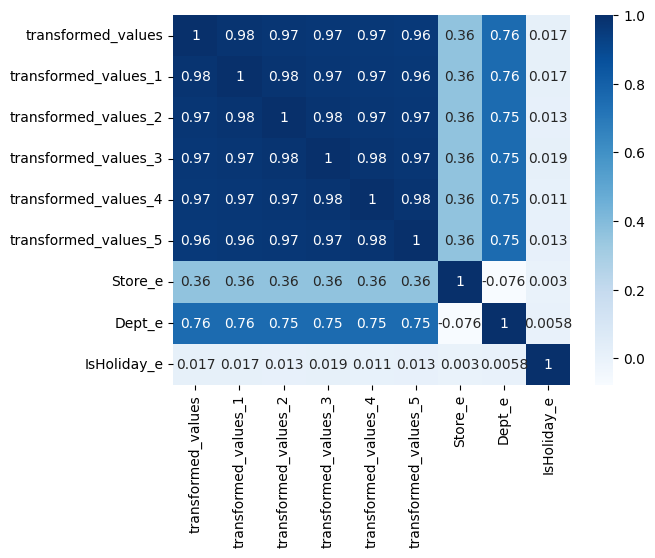

In [40]:
corr = df[['transformed_values','transformed_values_1','transformed_values_2','transformed_values_3',
          'transformed_values_4','transformed_values_5','Store_e','Dept_e', 'IsHoliday_e']].corr()

sns.heatmap(corr, annot=True, cmap="Blues")

In [46]:
X = df[['transformed_values_1','transformed_values_2','transformed_values_3',
          'transformed_values_4','transformed_values_5','Store_e','Dept_e', 'IsHoliday_e']]

y = df['transformed_values']

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [49]:
# Linear regression
lr = LinearRegression()
lr.fit(X_train, y_train)

# Decision tree regression
dt = DecisionTreeRegressor(random_state=42)
dt.fit(X_train, y_train)

# Random forest regression
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)

# Gradient boosting regression
gb = GradientBoostingRegressor(random_state=42)
gb.fit(X_train, y_train)

GradientBoostingRegressor(random_state=42)

In [50]:
# Make predictions
y_pred_lr = lr.predict(X_test)
y_pred_dt = dt.predict(X_test)
y_pred_rf = rf.predict(X_test)
y_pred_gb = gb.predict(X_test)

# Evaluate performance
mse_lr = mean_squared_error(y_test, y_pred_lr)
mse_dt = mean_squared_error(y_test, y_pred_dt)
mse_rf = mean_squared_error(y_test, y_pred_rf)
mse_gb = mean_squared_error(y_test, y_pred_gb)


In [56]:

r2_lr = r2_score(y_test, y_pred_lr)
r2_dt = r2_score(y_test, y_pred_dt)
r2_rf = r2_score(y_test, y_pred_rf)
r2_gb = r2_score(y_test, y_pred_gb)

In [52]:
# Perform cross-validation
scores_lr = cross_val_score(lr, X, y, cv=5, scoring="neg_mean_squared_error")
scores_dt = cross_val_score(dt, X, y, cv=5, scoring="neg_mean_squared_error")
scores_rf = cross_val_score(rf, X, y, cv=5, scoring="neg_mean_squared_error")
scores_gb = cross_val_score(gb, X, y, cv=5, scoring="neg_mean_squared_error")


In [57]:
# Print results
print("Linear regression:")
print("MSE: {:.4f}".format(mse_lr))
print("R2: {:.4f}".format(r2_lr))
print("Cross-validation scores: {}".format(-scores_lr))
print("Mean cross-validation score: {:.4f}".format(-scores_lr.mean()))
print("Standard deviation of cross-validation score: {:.4f}".format(scores_lr.std()))
print()

print("Decision tree regression:")
print("MSE: {:.4f}".format(mse_dt))
print("R2: {:.4f}".format(r2_dt))
print("Cross-validation scores: {}".format(-scores_dt))
print("Mean cross-validation score: {:.4f}".format(-scores_dt.mean()))
print("Standard deviation of cross-validation score: {:.4f}".format(scores_dt.std()))
print()

print("Random forest regression:")
print("MSE: {:.4f}".format(mse_rf))
print("R2: {:.4f}".format(r2_rf))
print("Cross-validation scores: {}".format(-scores_rf))
print("Mean cross-validation score: {:.4f}".format(-scores_rf.mean()))
print("Standard deviation of cross-validation score: {:.4f}".format(scores_rf.std()))
print()

print("Gradient boosting regression:")
print("MSE: {:.4f}".format(mse_gb))
print("R2: {:.4f}".format(r2_gb))
print("Cross-validation scores: {}".format(-scores_gb))
print("Mean cross-validation score: {:.4f}".format(-scores_gb.mean()))
print("Standard deviation of cross-validation score: {:.4f}".format(scores_gb.std()))
print()

Linear regression:
MSE: 3.6458
R2: 0.9700
Cross-validation scores: [2.41668552 5.00079754 2.73655657 5.97951267 2.49365948]
Mean cross-validation score: 3.7254
Standard deviation of cross-validation score: 1.4775

Decision tree regression:
MSE: 5.6121
R2: 0.9539
Cross-validation scores: [4.58607199 7.18625829 4.7881644  8.65483986 4.61325421]
Mean cross-validation score: 5.9657
Standard deviation of cross-validation score: 1.6637

Random forest regression:
MSE: 2.7544
R2: 0.9774
Cross-validation scores: [2.12920871 3.91956008 2.25262101 4.95046089 2.17811836]
Mean cross-validation score: 3.0860
Standard deviation of cross-validation score: 1.1494

Gradient boosting regression:
MSE: 3.3291
R2: 0.9726
Cross-validation scores: [2.31406244 4.57069601 2.57075441 5.62698496 2.32870987]
Mean cross-validation score: 3.4822
Standard deviation of cross-validation score: 1.3646

